In [2]:
import MySQLdb
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def loadKline(code):
    db = MySQLdb.connect("localhost", "root", "789", "stock", charset='utf8',port=3307 )
    db.query("""select * from company where code='%s'"""%code)
    r = db.store_result()
    company = r.fetch_row()
    db.query("""select volume,open,high,low,close,macd from kd_xueqiu where id=%s"""%company[0][0])
    r = db.store_result()
    k = r.fetch_row(r.num_rows())
    db.close()
    kline = torch.tensor(k).reshape(-1,6)
    return company,kline

In [4]:
"""
最小二乘法拟合直线
"""
def lastSequaresLine(x):
    a = torch.mean(x,dim=0)
    k = ((x[:,0]-a[0])*(x[:,1]-a[1])).sum()/((x[:,0]-a[0])**2).sum()
    b = a[1]-k*a[0]
    #拟合优度,范围0-1,越靠近1拟合越好
    R = 1-((x[:,1]-k*x[:,0]-b)**2).sum()/((x[:,1]-a[1])**2).sum()
    return torch.tensor([k,b,R])

"""
计算和直线l平行距离为d的另外两条直线
"""
def parallelLine(l,d):
    s = d*torch.sqrt(1+l[0]**2)
    return torch.tensor([l[0],l[1]+s]),torch.tensor([l[0],l[1]-s])

"""
计算点到直线的距离
"""
def distancePtLine(l,x):
    return (l[0]*x[:,0]-x[:,1]+l[1])/torch.sqrt(1+l[0]**2)

In [5]:
"""
向k线i后方搜索n个极值点位置
"""
def searchExtrePt(k,i,n=2):
    oi = i
    j = 0
    inx2 = [0 for a in range(n)]
    macd_i = k[i,5]
    mx = 0 if macd_i>0 else 100000
    while i>=0:
        macd = k[i,5]
        if macd*macd_i>0: #同号
            if macd>=0:
                if mx < k[i,1:5].max():
                    mx = k[i,1:5].max()
                    inx2[j] = i
            else:
                if mx > k[i,1:5].min():
                    mx = k[i,1:5].min()
                    inx2[j] = i
        elif j<n-1:
            j+=1
            macd_i = macd
            mx = k[i,1:5].max() if macd>0 else k[i,1:5].min()
            inx2[j] = i
        else:
            break
        i -= 1
    #print("searchExtrePt(%d,%d) (%d %d)"%(oi,n,inx2[0],inx2[1]))
    return inx2

"""将bi,ei范围内的k值表示成一组坐标点包括open,high,low,close"""
def KPts(k,bi,ei):
    y = k[bi:ei+1,1:5].reshape(-1)
    v = torch.empty(len(y),2)
    s = torch.linspace(bi,ei,ei-bi+1)
    for i in range(4):
        v[:,0].view(-1,4)[:,i] = s
    v[:,1] = y
    return v

"""
提取得K线的当前趋势线特征参数
返回[k,b,R,begin,end]
"""
def klineVector(k,i):
    inx2 = searchExtrePt(k,i,2)
    ei = i
    lv = torch.zeros(2,5)
    base = k[inx2[1],1]
    for j in range(2):
        bi = inx2[j]
        if ei-bi+1> 1:
            x = KPts(k,bi,ei)
            x[:,1] /= base
            lv[j,0:3] = lastSequaresLine(x)
            lv[j,3] = bi
            lv[j,4] = ei
            print("fitLine: %d-%d line=%s"%(bi,ei,lv[j]))
            ei = bi
    return lv
            
"""
绘制当前K线的趋势线图
"""
def klineVectorPlot(k,lv,i):
    fig, axs = plt.subplots(1, 1, figsize=(16, 8))
    #axs[0].axis('equal')
    inxs = searchExtrePt(k,i)
    
    bi = inxs[1]
    ei = i
    x = torch.linspace(bi,ei,ei-bi+1)
    base = k[bi,1]
    open1 = k[bi:ei+1,1]/base
    high = k[bi:ei+1,2]/base
    low = k[bi:ei+1,3]/base
    close = k[bi:ei+1,4]/base
    #axs.scatter(x,open1,label='open',color='blue')
    #axs.scatter(x,high,label='high',color='red')
    #axs.scatter(x,low,label='low',color='green')
    axs.scatter(x,close,label='close',color='orange')
    print(lv[0])
    print(lv[1])
    x1 = torch.linspace(lv[0][3],lv[0][4],int((lv[0][4]-lv[0][3]).item()))
    x2 = torch.linspace(lv[1][3],lv[1][4],int((lv[1][4]-lv[1][3]).item()))
    y1 = lv[0][0]*x1+lv[0][1]
    y2 = lv[1][0]*x2+lv[1][1]
    axs.plot(x1,y1,label='line1')
    axs.plot(x2,y2,label='line2')
    
    #axs[1].stem(dx[0:-1], d, use_line_collection=True)
    axs.legend()
    plt.show()

In [6]:
c,kline = loadKline('SH000001')

In [7]:
def showKVector(i):
    lv = klineVector(kline,i)
    klineVectorPlot(kline,lv,i)

fitLine: 1481-1490 line=tensor([ 3.6125e-03, -4.3862e+00,  7.4778e-01,  1.4810e+03,  1.4900e+03])
fitLine: 1466-1481 line=tensor([-1.8628e-04,  1.2709e+00,  5.0304e-03,  1.4660e+03,  1.4810e+03])
tensor([ 3.6125e-03, -4.3862e+00,  7.4778e-01,  1.4810e+03,  1.4900e+03])
tensor([-1.8628e-04,  1.2709e+00,  5.0304e-03,  1.4660e+03,  1.4810e+03])


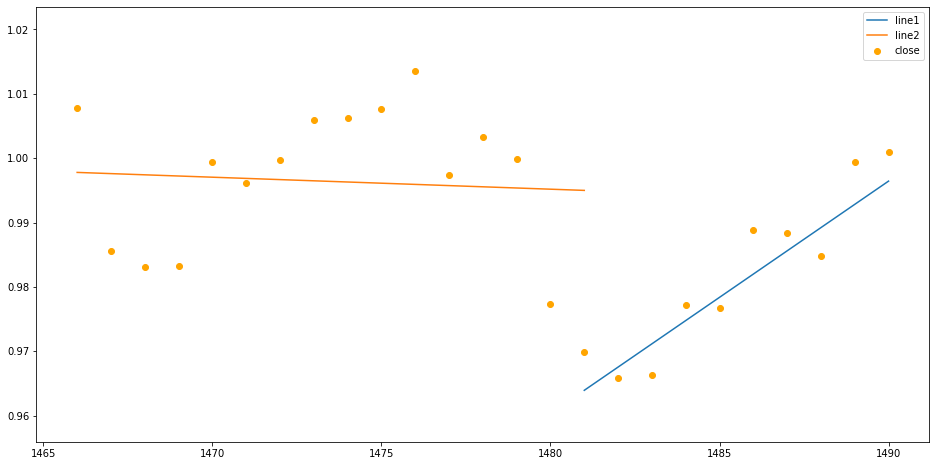

In [8]:
showKVector(1490)

In [9]:
def showK(k,bi,ei):
    fig, axs = plt.subplots(2, 1, figsize=(16, 16))
    x = torch.linspace(bi,ei,ei-bi+1)
    #print('range %d,%d,k=%s'%(bi,ei,k[bi:ei+1,4]))
    macd = k[bi:ei+1,5]
    axs[0].scatter(x,k[bi:ei+1,1],label='open',color='blue')
    axs[0].scatter(x,k[bi:ei+1,2],label='high',color='red')
    axs[0].scatter(x,k[bi:ei+1,3],label='low',color='green')
    axs[0].scatter(x,k[bi:ei+1,4],label='close',color='red')
    axs[1].stem(x, macd, use_line_collection=True)
    plt.show()

# 计算K线的全部拟合直线线


拟合方法：  
1. 使用区间的概念，要求在拟合直线必须穿过全部的拟合数据区间
2. ...

In [10]:
"""搜索出k线的上的全部macd极值点"""
def searchMacdExtrePt(k):
    epts = []
    macd = k[0,5]
    mi = 0
    mx = 0 if macd>=0 else 100000
    mm = macd
    for i in range(len(k)):
        curmacd = k[i,5]
        if curmacd*macd>0:
            if macd>=0:
                if mx<k[i,1:4].max():
                    mx = k[i,1:4].max()
                    mi = i
                    mk = k[i]
                    mm = curmacd
            else:
                if mx>k[i,1:4].min():
                    mx = k[i,1:4].min()
                    mi = i
                    mk = k[i]
                    mm = curmacd
        else:
            macd = curmacd
            epts.append({"pos":mi,"exv":mx,"macd":mm})
            mx = 0 if macd>=0 else 100000
    #将最后的点放入
    if mi!=epts[-1][0]:
        epts.append({"pos":mi,"exv":mx,"macd":mm})
    return epts

"""拟合折线，考虑到需要用此折线进行收益率估算，因此匹配点必须被依次找出，防止将未来的信息带入到折线数据中"""
def fitPolyline(x):
    pass

"""拟合全部极值直线与次级折线"""
def fitMacdExtreLine(k,epts):
    for i in range(1,len(epts)):
        if epts[i-1]["macd"]*epts[i]["macd"]<0:#确定两点在不同的macd区间
            x = KPts(k,epts[i-1]["pos"],epts[i-1]["pos"])
            epts[i]["fitbegin"] = epts[i-1]["pos"]
            epts[i]["fitend"] = epts[i]["pos"]
            epts[i]["fitline"] = lastSequaresLine(x)
            epts[i]["polyline"] = fitPolyline(x)
    return epts

In [11]:
"""判断直线是否穿过指定区间"""
def isCrossLine(l,c):
    y = l[0]*c[0]+l[1]
    return y<=c[1] and y>=c[2]
"""判断当前直线表中的直线是不是有穿过c的"""
def existCrossLine(lt,c):
    k_min = 100000
    k_max = -100000
    for l in lt:
        if k_max < l[0]:
            k_max = l[0]
            b_max = l[1]
        if k_min > l[0]:
            k_min = l[0]
            b_min = l[1]
    y0 = k_max*c[0]+b_max
    y1 = k_min*c[0]+b_min
    return min(y0,y1) < c[1] and max(y0,y1) > c[2]

"""将新约束条件加上"""
def addConstraint(lt,cs,c):
    for s in cs:
        dx = s[0]-c[0]
        #high 1 - high 1
        k = (s[1]-c[1])/dx
        b = c[1]-k*c[0]
        lt.append([k,b])
        #low 2 - low 2
        k = (s[2]-c[2])/dx
        b = c[2]-k*c[0]
        lt.append([k,b])
        #high 1 - low 2 
        k = (s[1]-c[2])/dx
        b = c[2]-k*c[0]
        lt.append([k,b])
        #low 2 - high 1
        k = (s[2]-c[1])/dx
        b = c[1]-k*c[0]
        lt.append([k,b])
        
"""每一直线都必须穿过每一个约束，否则就删除该直线"""
def clearConstraintLine(lt,cs):
    for l in lt[:]:
        for c in cs:
            if not isCrossLine(l,c):
                lt.remove(l)
                break
"""使用每个k线点向前画一条直线，要求直线穿过最多的过去k点，并计算直线的斜率取值范围"""
def fitTangentLine(k,i):
    lt = []
    cs = []
    for j in range(0,i+1):
        c = [-j,k[i-j,2],k[i-j,3]] #0 x, 1. high 2. low
        if j==0:
            cs.append(c)
        elif j==1:
            addConstraint(lt,cs,c)
            cs.append(c)
        else:
            if existCrossLine(lt,c):
                addConstraint(lt,cs,c)
                cs.append(c)
                clearConstraintLine(lt,cs)
            else:
                break
    t = torch.tensor(lt)
    #做一个向下的范围预测k*x+b
    p = t[:,0]+t[:,1]
    #函数返回最大k,最小k,穿过过往数据数量，预测下一天的最大值，和下一天的最小值，以及约束直线的数量
    return (t[:,0].max(),t[:,0].min(),len(cs),p.max(),p.min(),len(lt))

def fitAllKlineTangentLine(k):
    tk = torch.empty(len(k),6)
    tk[0] = 0
    for i in range(1,len(k)):
        tk[i] = torch.tensor(fitTangentLine(k,i))
    return tk

def showTangentLineAt(k,i):
    pass

In [12]:
fitTangentLine(kline,3506)

(tensor(3.4778), tensor(3.3714), 12, tensor(2061.1755), tensor(2060.9626), 2)

In [56]:
"""计算收益率"""
def calcProfit(k,tk,bi,ei):
    r = 1.
    prev = (tk[bi,0]+tk[bi,1])/2
    buy = -1
    tr = []
    for i in range(bi+1,ei):
        current = (tk[i,0]+tk[i,1])/2
        if prev * current < 0:
            close = k[i,4]
            if current>0:
                buy = close
                buyi = i
            elif buy>0:
                tr.append([buyi,i,buy,close])
                r *= close/buy
                buy = -1
            prev = current
    return r,torch.tensor(tr)

"""计算macd收益率"""
def calcMacdProfit(k,bi,ei):
    r = 1.
    prev = k[bi,5]
    buy = -1
    tr = []
    for i in range(bi+1,ei):
        macd = k[i,5]
        if macd*prev<0:
            close = k[i,4]
            if macd>0:
                buy = close
                buyi = i
            elif buy>0:
                tr.append([buyi,i,buy,close])
                r *= close/buy
                buy = -1
            prev = macd
    return r,torch.tensor(tr)

"""显示k线图和切线"""
def showTangentLine(k,tk,bi,ei):
    widths = [1]
    heights = [5,3,1]
    gs_kw = dict(width_ratios=widths, height_ratios=heights)    
    fig, axs = plt.subplots(3, 1, figsize=(28, 16),gridspec_kw = gs_kw)

    x = torch.linspace(bi,ei,ei-bi+1)
    high = k[bi:ei+1,2]
    low = k[bi:ei+1,3]
    axs[0].scatter(x,high,label='high',color='red')
    axs[0].scatter(x,low,label='low',color='green')
    axs[0].plot(x,high,color='red')
    axs[0].plot(x,low,color="green")
    
    #显示交易点
    mrate,tr = calcMacdProfit(k,bi,ei)
    print("MACD %.4f"%mrate)
    axs[0].scatter(tr[:,0],tr[:,2],label='buy',color='blue')
    axs[0].scatter(tr[:,1],tr[:,3],label='sell',color='yellow')
    mrate,tr = calcProfit(k,tk,bi,ei)
    print("Tangent %.4f"%mrate)
    axs[0].scatter(tr[:,0],tr[:,2],label='buy1',marker=">",s=180,alpha=0.5)
    axs[0].scatter(tr[:,1],tr[:,3],label='sell1',marker="<",s=180,alpha=0.5)    
    axs[0].grid(True)
    
    axs[1].plot(x,(tk[bi:ei+1,0]+tk[bi:ei+1,1])/2,color='red')
    axs[1].scatter(x,(tk[bi:ei+1,0]+tk[bi:ei+1,1])/2,color='red')
    #axs[1].plot(x,tk[bi:ei+1,0],color='red')
    #axs[1].plot(x,tk[bi:ei+1,1],color='green')
    axs[1].plot(x,torch.zeros(ei-bi+1),color='black') #0轴
    axs[1].grid(True)
    
    #axs[2].plot(x,tk[bi:ei+1,2],color='blue')
    #axs.plot(x1,y1,label='line1')
    #axs.plot(x2,y2,label='line2')
    macd = k[bi:ei+1,5]
    axs[2].stem(x, macd, use_line_collection=True)
    axs[2].grid(True)
    #axs.legend()
    plt.show()

In [14]:
tk = fitAllKlineTangentLine(kline)

MACD 0.9737
Tangent 0.9352


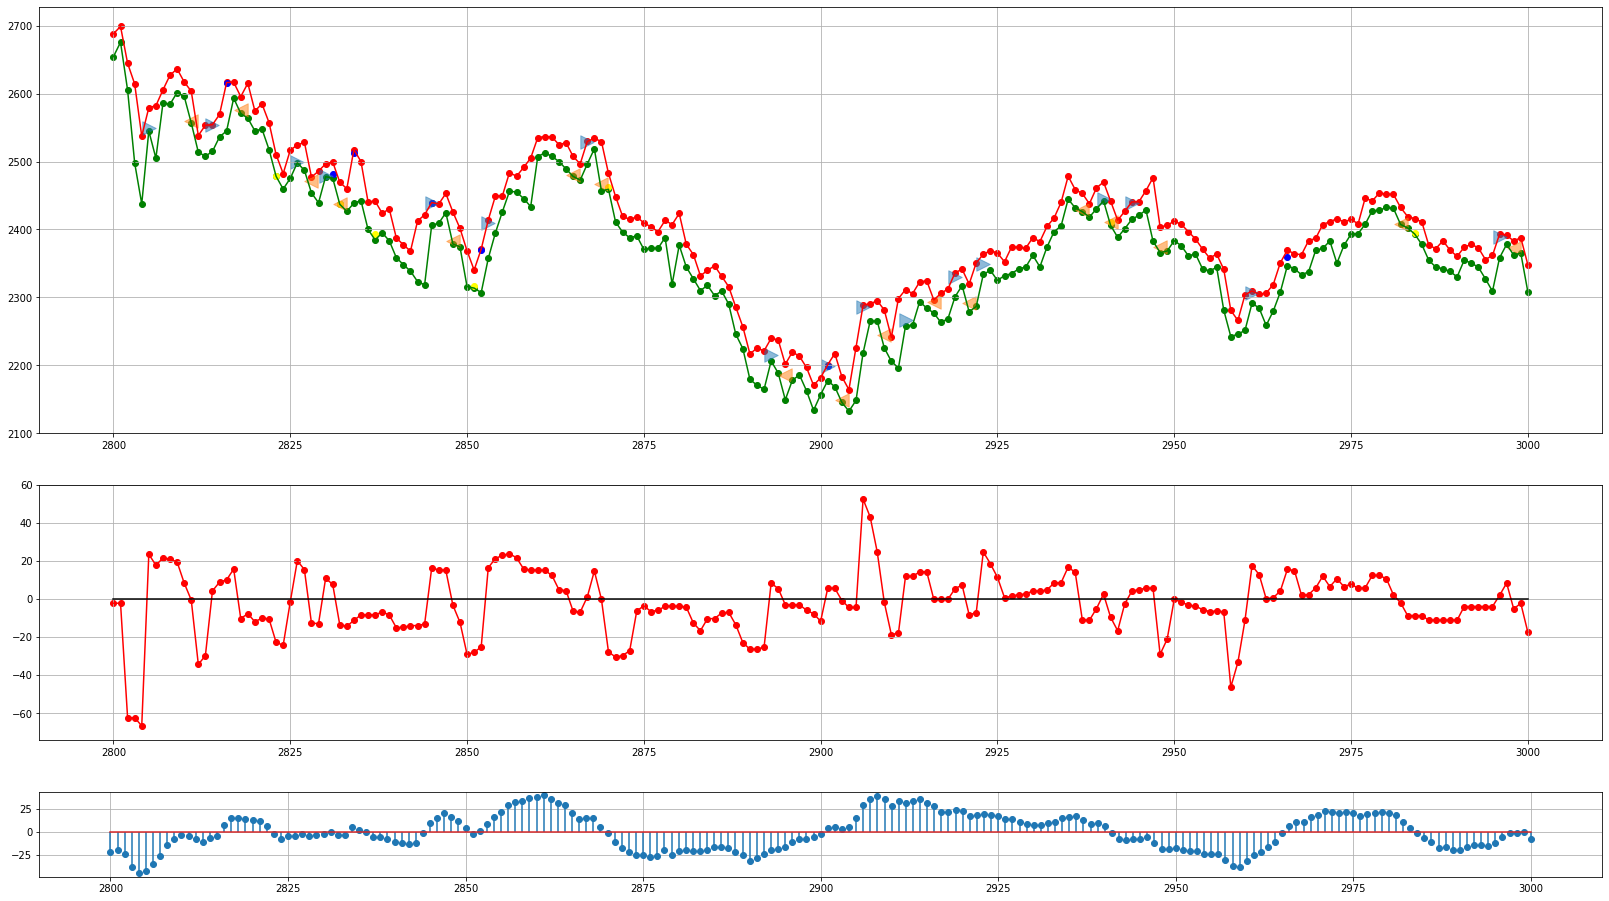

In [57]:
showTangentLine(kline,tk,2800,3000)